# Market Regime Detection with Clustering

<sub>**by Aung Si**</sub><br>
<sub>June 21<sup>st</sup>, 2023</sub>

---

## Before We Begin

#### *The Math*
I've explained the mathematical basis behind the tools used in this paper in the Appendix.

#### *Organization of Code*
In this analysis, I've employed a modular approach to the code. Most of the code blocks follow the following format:
1. Defining helper functions necessary for the portion of analysis.
2. Utilising these helper functions to execute the specific analysis task or to generate results.

This way, the code is kept organized and replicability is made easy.

#### *Disclaimer*
*The information provided in this analysis is for informational purposes only and should not be construed as investment advice. All analysis and commentary presented are based on publicly available returns at the time of the analysis. The interpretations and conclusions are those of the author and do not necessarily represent the views of any company or its affiliates. Past performance does not guarantee future results. Investors should seek professional financial advice before making any investment decisions based on this analysis.*

---

## Introduction

### The Significance of Clustering
Financial markets thrive on the detection of distinct regimes. Regimes signify periods with similar market behavior, revealing patterns, trends, volatilities, and more - the response of investors in light of such changing regimes is paramount to their success. Clustering methods like K-Means, Hierarchical, DBSCAN, and Spectral serve to segment market data based on the behaviors of features chosen for analysis and reveal distinct regimes in which the chosen features behave differently. As an example, the regime of the stock market during the COVID-19 pandemic may be one characterized by high returns, but also high volatility. The period following the brunt of the pandemic may be one characterized by an entirely different feature profile. Clustering techniques help capture such heterogeneities in the market and expose regime shifts missed by traditional methods and intuition. By segmenting market behavior into different regimes based on different features, clustering identifies important regime boundaries, thereby enabling investors to be more adaptable, swift, and decisive with their strategies and allocations. NVIDIA has [this article](https://www.nvidia.com/en-us/glossary/data-science/clustering/) on clustering.

### Chosen Ticker and Features
For this paper, I've chosen the SPY ETF ([SPDR S&P 500 ETF Trust](https://www.ssga.com/us/en/intermediary/etfs/funds/spdr-sp-500-etf-trust-spy)) as a proxy for the stock market. I've also chosen the following features to characterize each regime:
1. Returns
2. Moving Standard Deviation of Returns
3. Moving Average Return
4. Moving Skewness of Returns
5. Moving Kurtosis of Returns
6. Moving Autocorrelation of Returns
7. Jump (I've defined jump to be any point in time where returns 'jump' below or above the Bollinger Bands of one standard deviation away from the moving average return.)

I'll explain my rationale for the choice of features later in the paper.

### Chosen Clustering Techniques
1. [<u>**K-Means Clustering**</u>](https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/) - partitions returns into a predetermined number of clusters. It aims to minimize the within-cluster sum of squares by iteratively assigning returns points to the cluster with the closest mean and updating the cluster centroids. K-Means clustering is suitable for returns where the number of clusters is known or can be estimated.

2. [<u>**Hiearchical Clustering**</u>](https://www.displayr.com/what-is-hierarchical-clustering/#:~:text=Hierarchical%20clustering%2C%20also%20known%20as,broadly%20similar%20to%20each%20other.) - builds a hierarchy of clusters by iteratively merging or splitting clusters based on their similarity. It can be represented using a dendrogram, which shows the hierarchical relationships between clusters. Hierarchical clustering can be either agglomerative (bottom-up) or divisive (top-down), and it does not require specifying the number of clusters in advance.

3. [<u>**DBSCAN Clustering**</u>](https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/#:~:text=DBSCAN%20is%20a%20density%2Dbased,points%20into%20a%20single%20cluster.) - a density-based clustering algorithm that groups together returns points that are close to each other and have a sufficient number of neighboring points, while identifying noise points as outliers. DBSCAN is particularly useful for returns sets with irregularly shaped clusters and varying densities.

4. [<u>**Spectral Clustering**</u>](https://towardsdatascience.com/spectral-clustering-aba2640c0d5b) - combines elements of graph theory and dimensionality reduction. It treats returns points as nodes in a graph and performs clustering based on the graph's Laplacian matrix. Spectral clustering can uncover complex nonlinear structures and is effective for returns with well-defined clusters but no clear separation boundaries.

The math and logic behind each clustering algorithm is explored in brief in the Appendix. 

Each of these algorithms can be imported from the `sklearn.cluster` module from `scikit-learn`, which itself can be installed with the notebook command `!pip install scikit-learn`.

---

## Analysis and Code

### 1. Preliminary Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from QuantFuncs import get_pricing, fmt

### 2. Data Gathering / Processing

For our analysis the basis of our data will the prices of the S&P500 Index. All of the features will be computed off of the returns of SPY, which is computed from its price series.

In [2]:
# FETCHING STOCK PRICES AND RETURNS DATA.
# ==============================================================================================================

def get_returns(prices):
    return pd.DataFrame(np.log(prices).diff()).rename(columns={'Close': 'returns'})
# --------------------------------------------------------------------------------------------------------------

start = '2023-01-01'
end = '2023-06-21'
ticker = 'SPY'

prices = get_pricing(ticker, start=start, end=end)
returns = get_returns(prices)
returns.head()

,returns
Date,
2023-01-03,NaN
2023-01-04,0.007691
2023-01-05,-0.011479
2023-01-06,0.022673
2023-01-09,-0.000567


### 3. Feature Engineering and Rationale for Choice of Features

As mentioned before, the features chosen for this paper are:

1. Returns
2. Moving Standard Deviation of Returns
3. Moving Average Return
4. Moving Skewness of Returns
5. Moving Kurtosis of Returns
6. Moving Autocorrelation of Returns
7. Jump

I've chosen these features for the following reasons:

- <u>Encapsulation of Different Aspects of Market Behavior</u> - Each chosen feature represents a distinct aspect of market behavior, contributing to a comprehensive understanding of regime shifts. High values for returns signify strong overall performance, while high values for the moving standard deviation of returns indicate greater volatility in the market. A high moving average return suggests an upward trend, while high values for moving skewness and kurtosis indicate a skewed and fat-tailed distribution, respectively. Positive moving autocorrelation implies a persistent market trend, while jumps capture significant deviations from the moving average, representing sudden and noteworthy market movements. On the other hand, low values for these features represent contrasting characteristics, such as lower returns, lower volatility, a more stable trend, a more symmetric distribution, weaker persistence, and fewer notable jumps.

- <u>Relatively Comprehensive Representation and Differentiation of Regimes</u> - The chosen features offer a relatively comprehensive representation of regimes by considering multiple aspects of market behavior. Clustering based on these features enables the identification of distinct regimes characterized by specific combinations of behaviors. For example, a regime with high returns, high volatility, and positive skewness may indicate a bullish market with growth opportunities, while a regime with low returns, low volatility, and negative skewness may represent a stable or bearish market. High autocorrelation combined with high volatility may suggest momentum-driven regimes, and so on and so forth.

Some limitations include:

- <u>Market-Inherent Features based on the Assumption of Linearity</u> -  The selected features primarily focus on statistical properties derived from price returns and do not directly account for external market factors. Factors such as macroeconomic indicators, industry-specific information, or market sentiment can significantly influence market regimes but are not explicitly incorporated into the feature set. Therefore, the analysis may not fully capture the comprehensive range of factors impacting regime shifts. The chosen features also assume linear relationships and stationary properties of market behavior. However, market dynamics often exhibit non-linearities and time-varying characteristics. Ignoring non-linear relationships and time-varying dynamics may limit the accuracy and completeness of regime detection, potentially overlooking nuanced patterns and transitions in market states.

- <u>Incomplete Consideration of Market Liquidity</u> - The selected features do not explicitly incorporate measures of market liquidity, which can significantly impact market behavior and regime shifts. The exclusion of liquidity-related factors, such as bid-ask spreads, trading volumes, or market depth, may be to the detriment of our regime analysis.

- <u>Potential Feature Redundancy</u> - Some features may exhibit strong correlations, leading to redundant information. Redundancy in the feature set can influence the clustering analysis and the interpretability of the identified regimes.

In [3]:
# FEATURE ENGINEERING.
# ==============================================================================================================

def jump_condition(data, std_threshold):
    return ((data['returns'] > data['ma'] + std_threshold * data['volatility']) | 
            (data['returns'] < data['ma'] - std_threshold * data['volatility'])).astype(int)

def autocorr(data, window, autocorr_lag):
    return data['returns'].rolling(window).apply(lambda x: x.autocorr(lag=autocorr_lag), raw=False)

def engineer_features(returns, window=20, std_threshold=2, autocorr_lag=2):
    data = returns.copy()
    data['volatility'] = data['returns'].rolling(window).std()
    data['ma'] = data['returns'].rolling(window).mean()
    data['skew'] = data['returns'].rolling(window).skew()
    data['kurt'] = data['returns'].rolling(window).kurt()
    data['autocorr'] = autocorr(data, window, autocorr_lag)
    data['jump'] = jump_condition(data, std_threshold)
    return data[window:]
# --------------------------------------------------------------------------------------------------------------

window = 20
std_threshold = 2
autocorr_lag = 2
data = engineer_features(returns, window=window, std_threshold=std_threshold, autocorr_lag=autocorr_lag)
data[data['jump'] == 1].head()

,returns,volatility,ma,skew,kurt,autocorr,jump
Date,,,,,,,
2023-04-25,-0.016001,0.007186,0.001195,0.048874,1.113183,0.147618,1
2023-04-27,0.019712,0.007834,0.001359,0.443603,1.385875,-0.435628,1


Let's check the correlation of our features as a sanity check.

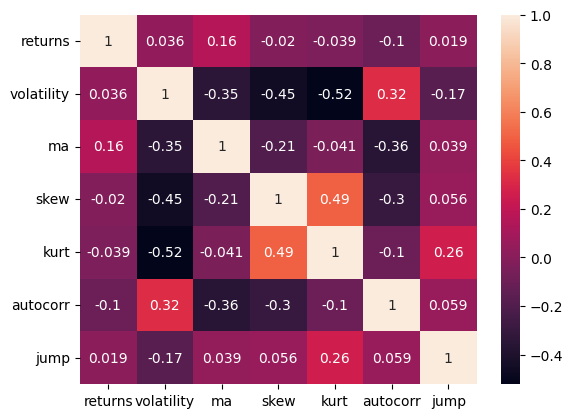

In [4]:
sns.heatmap(data.corr(), annot=True);

Thankfully our features don't seem to be too correlated, save for a few with (relatively) strong negative correlations. A few that warrant attention:

$$\rho_{\sigma,\text{ kurt}}=-0.52$$
$$\rho_{\sigma,\text{ skew}}=-0.45$$
$$\rho_{\sigma,\text{ ma}}=-0.35$$
 
The negative correlation between volatility and kurtosis suggests that higher market volatility often corresponds with fewer extreme outliers, and vice versa. This pattern might influence our clustering outcome by creating groups where these attributes' states are intertwined.

Similarly, the negative correlation between volatility and skewness can have intriguing implications. High-volatility periods may coincide with a negatively skewed distribution, meaning clustering might group together instances characterized by high volatility and negative skew or low volatility and positive skew.

Moreover, the moving average return's negative correlation with volatility signals that more volatile market periods tend not to align closely with their recent trends. This relationship could further inform clustering by forming clusters representing periods of high volatility deviating from trends or low volatility closely following trends.

In the context of cluster analysis, these correlations are, indeed, beneficial. The distinctness they introduce adds complexity and richness to our data, likely leading to more pronounced clusters. However, it's crucial to remember that perfectly correlated features, either positively or negatively, don't contribute new information. They may lead to issues such as multicollinearity in some machine learning models. Fortunately, in our scenario, the features aren't too strongly correlated, implying each can contribute unique and valuable information to the clustering process.

### 4. Scaling features for Clustering

Now I'll scale the data to ensure that all features are on a comparable scale and to prevent certain features from dominating the clustering analysis. Scaling is particularly crucial for distance-based algorithms like K-Means or DBSCAN, as these algorithms are highly sensitive to variations in feature scales. I'll use `StandardScaler` from the `scikit-learn` library to standardize the numerical features, thereby transforming them to have a zero mean and unit variance. However, the binary feature `jump` is excluded from scaling as it represents numerical booleans rather than continuous values. `jump` is then re-appended to the scaled features.

Scaling is generally recommended for each of the clustering algorithms due to the following reasons:

1. <u>Disproportionate influence</u> - Without scaling, features with larger magnitudes or wider ranges can overpower other features, potentially overshadowing their contributions to the clustering outcome.

2. <u>Inaccurate comparisons</u> - Differences in feature scales can lead to inaccurate comparisons between features, affecting the overall clustering results and obscuring meaningful patterns.

3. <u>Bias in distance-based algorithms</u> - Distance-based algorithms, such as K-Means and DBSCAN, are influenced by feature scales. Features with larger scales may dominate the distance calculations, reducing the impact of features with smaller scales.

4. <u>Convergence issues</u> - Inadequate scaling can result in convergence problems or slow convergence rates during the clustering optimization process, affecting the stability and efficiency of the clustering algorithms.

However, scaling might be unnecessary or undesirable in certain scenarios, such as when dealing with categorical variables or predefined binary features (like our `jump` variable). In these cases, where the features do not have a continuous numerical interpretation, scaling is not required. This [thread on StackExchange](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering) sheds more light on scaling and its uses in clustering.

In [5]:
# IMPORT SCALER.
# ==============================================================================================================

from sklearn.preprocessing import StandardScaler

In [6]:
# SCALE DATA FOR CLUSTERING.
# ==============================================================================================================

def scale(data):
    scaler = StandardScaler()
    binary_ommitted_df = data[[column for column in data.columns if column != 'jump']] # Omit the jump variable.
    scaled_data = scaler.fit_transform(np.array(binary_ommitted_df).T)
    jump_feature = np.array(data['jump']).reshape(-1, 1)
    return np.concatenate((scaled_data.T, jump_feature), axis=1) # Re-append the jump variable.
# --------------------------------------------------------------------------------------------------------------

scaled_data = scale(data)

### 5. Clustering

We now import `KMeans`, `AgglomerativeClustering` (Hierarchical), `DBSCAN`, `SpectralClustering` from `sklearn.cluster` and perform clustering using the features we've chosen. To characterize the nature of each regime detected by each clustering algorithm, we calculate the mean value of the features within each regime through the `cluster_averages` function.

In [7]:
# IMPORT CLUSTERING FUNCTIONS.
# ==============================================================================================================

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering

#### Parameter Selection
For all of the clustering algorithms except for DBSCAN (which detects its own number of clusters), I've chosen $n=2$ clusters. This choice is guided by the dramatic events that marked the first half of 2023, such as the [Silicon Valley Bank Collapse](https://www.theguardian.com/business/2023/mar/17/why-silicon-valley-bank-collapsed-svb-fail). We can then reasonably expect the data to reflect at least two distinct market conditions. The first regime could potentially represent periods of increased volatility and unpredictability caused by these events, while the second regime could correspond to periods of relative stability and predictability amidst the chaos. While this is a simplification of the complex dynamics at play, it serves as a useful starting point for our analysis. Keep in mind that clustering is an exploratory technique and the actual market conditions may deviate from these expectations.

- `n_clusters = 2` - As discussed, we hypothesize that our data can be separated into two distinct regimes reflecting different market conditions. This parameter applies to K-Means, Hierarchical, and Spectral Clustering, which require the number of clusters to be specified in advance.

- `random_state = 42` - This parameter is specific to the K-Means clustering algorithm. It controls the random seed for the initial centroid placement, ensuring that our results are repeatable. The number 42 was chosen arbitrarily - it has no special significance in this context.

- `eps = 0.5` and `min_samples = 5` - These parameters apply to the DBSCAN clustering method. `eps` refers to the maximum distance between two samples for them to be considered as in the same neighborhood. A smaller eps value means that clusters will have to be closer together. `min_samples` is the number of samples in a neighborhood for a data point to qualify as a core point. These values were chosen to allow for some flexibility in cluster shape and density, while still ensuring a reasonable number of samples in each cluster.

- `affinity = 'nearest_neighbors'` - This parameter is specific to Spectral Clustering and determines how data points are compared to each other. By choosing `'nearest_neighbors'`, we instruct the algorithm to consider data points with a smaller Euclidean distance as more similar. This method can be advantageous when dealing with data where close proximity indicates similarity, which is often the case in financial time series.

In [22]:
# CONDUCT CLUSTERING.
# ==============================================================================================================

def kmeans_cluster(data, scaled_data, n_clusters, random_state, n_init='auto'):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init)
    kmeans.fit(scaled_data)
    data['kmeans_regime'] = kmeans.labels_

def hiearchical_cluster(data, scaled_data, n_clusters):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    agg_clustering.fit(scaled_data)
    data['hierarchical_regime'] = agg_clustering.labels_

def dbscan_cluster(scaled_data, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(scaled_data)
    data['dbscan_regime'] = dbscan.labels_
    data['dbscan_regime'] = data['dbscan_regime'].replace(-1, max(dbscan.labels_) + 1)

def spectral_cluster(scaled_data, n_clusters, affinity):
    spectral = SpectralClustering(n_clusters=n_clusters, affinity=affinity)
    spectral.fit(scaled_data)
    data['spectral_regime'] = spectral.labels_

# Returns the mean value of the features within each regime produced by each clustering algorithm.
def cluster_absolute_averages(data):
    regimes = [f'{i}_regime' for i in ['kmeans', 'hierarchical', 'dbscan', 'spectral']]
    cluster_abs_avgs = {regime: data.groupby(regime).mean() for regime in regimes}
    return cluster_abs_avgs

def mass_cluster(data, scaled_data, n_clusters, random_state, eps, min_samples, affinity):
    features = ['returns', 'volatility', 'ma', 'skew', 'autocorr', 'jump']
    kmeans_cluster(data, scaled_data, n_clusters, random_state, n_init='auto')
    hiearchical_cluster(data, scaled_data, n_clusters)
    dbscan_cluster(scaled_data, eps, min_samples)
    spectral_cluster(scaled_data, n_clusters, affinity)
    cluster_abs_avgs = {
        key.replace('_regime', ''): value[features] for key, value in cluster_absolute_averages(data).items()
    }
    return data, cluster_abs_avgs
# --------------------------------------------------------------------------------------------------------------

n_clusters = 2 # Two clusters hypothesized.
random_state = 42
eps = 0.5
min_samples = 5
affinity = 'nearest_neighbors'
data, cluster_abs_avgs = mass_cluster(data, scaled_data, n_clusters, random_state, eps, min_samples, affinity)

for avgs in cluster_abs_avgs.values():
    display(avgs)

,returns,volatility,ma,skew,autocorr,jump
kmeans_regime,,,,,,
0,0.000800,0.008283,0.001098,0.380611,-0.259285,0.052632
1,0.000632,0.009961,0.000646,-0.089729,-0.205342,0.000000


,returns,volatility,ma,skew,autocorr,jump
hierarchical_regime,,,,,,
0,0.000380,0.008362,0.001011,0.375537,-0.252518,0.051282
1,0.000911,0.009936,0.000696,-0.094427,-0.208962,0.000000


,returns,volatility,ma,skew,autocorr,jump
dbscan_regime,,,,,,
0,0.000911,0.009936,0.000696,-0.094427,-0.208962,0.00
1,-0.002681,0.008147,0.000109,0.664052,-0.421953,0.00
2,0.006188,0.009043,0.000333,0.675492,-0.373951,0.00
3,0.000321,0.008304,0.001472,0.211681,-0.167234,0.08


,returns,volatility,ma,skew,autocorr,jump
spectral_regime,,,,,,
0,0.000297,0.009416,0.000456,0.172495,-0.158992,0.03125
1,0.001475,0.009085,0.001534,-0.056682,-0.357348,0.00000


Next, we'll transform the `scaled_data` array into a dataframe that aligns with our original `data` dataframe. The distinction between these two dataframes is crucial when it comes to data visualization. When we plot the averages derived from the scaled_data dataframe, we are looking at the *relative* mean values of each feature. Though these values do not represent the actual averages, they allow us to make effective comparisons between the normalized scales of each feature. On the other hand, plotting the averages from the data dataframe shows us the *absolute* mean values, that is, the true mean values of each feature. While this gives us precise means of each feature, it may not be as visually informative due to inherent scale differences among features like skew, kurtosis, and autocorrelation compared to daily returns and volatility.

In [9]:
# CONVERT `SCALED_DATA` ARRAY INTO A DATAFRAME THAT ALIGNS WITH THE `DATA` DATAFRAME.
# ==============================================================================================================
def add_regime_cols(data, scaled_data):
    scaled_data = pd.DataFrame(scaled_data)
    regimes = [f'{i}_regime' for i in ['kmeans', 'hierarchical', 'dbscan', 'spectral']]
    for regime in regimes:
        scaled_data[regime] = data[regime]
    return scaled_data

def scaled_data_df(data, scaled_data):
    scaled_data = add_regime_cols(data, scaled_data)
    scaled_data.index, scaled_data.columns = data.index, data.columns
    return scaled_data

def cluster_relative_averages(data, scaled_data):
    scaled_data = scaled_data_df(data, scaled_data)
    regimes = [f'{i}_regime' for i in ['kmeans', 'hierarchical', 'dbscan', 'spectral']]
    cluster_rel_avgs = {regime: scaled_data.groupby(regime).mean() for regime in regimes}
    return cluster_rel_avgs

def scaled_data_df_and_rel_averages(data, scaled_data):
    scaled_data = scaled_data_df(data, scaled_data)
    features = ['returns', 'volatility', 'ma', 'skew', 'autocorr', 'jump']
    cluster_rel_avgs_items = cluster_relative_averages(data, scaled_data).items()
    cluster_rel_avgs = {
        key.replace('_regime', ''): value[features] for key, value in cluster_rel_avgs_items
    }
    return scaled_data, cluster_rel_avgs
# --------------------------------------------------------------------------------------------------------------
scaled_data, cluster_rel_avgs = scaled_data_df_and_rel_averages(data, scaled_data)

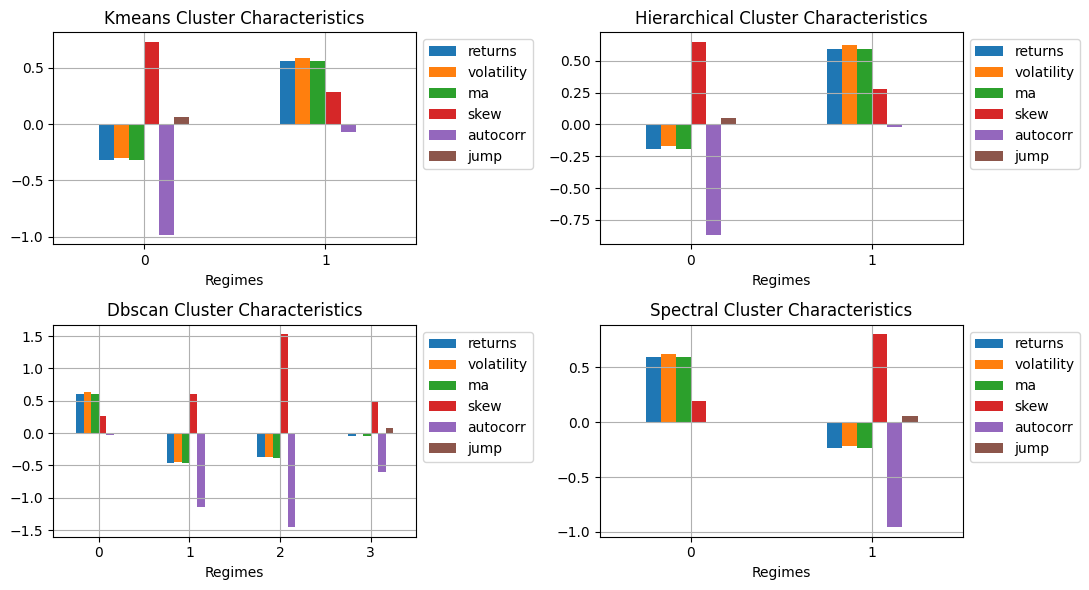

In [10]:
# PLOT CLUSTER CHARACTERISTICS.
# ==============================================================================================================

def plot_cc(characteristic, cluster_kind, ax):
    characteristic.plot(kind='bar', ax=ax)
    ax.set_xticklabels(characteristic.index, rotation=0)
    ax.set_title(f'{cluster_kind.title()} Cluster Characteristics')
    ax.legend(bbox_to_anchor=(1,1))
    ax.set_xlabel('Regimes')
    ax.grid(True)
# --------------------------------------------------------------------------------------------------------------

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 6))
cluster_methods = [label.replace('_regime', '') for label in data.columns if 'regime' in label]

for i, ax in enumerate(axes.flat):
    cluster_method = cluster_methods[i]
    plot_cc(cluster_rel_avgs[cluster_method], cluster_method, ax)

plt.tight_layout()
plt.show()

### 6. Interpreting the Regimes

#### K-Means and Hierarchical Clustering

- <u>Regime 1</u> - This regime is characterized by higher volatility (approximately 0.59 standard deviations above the mean), a larger average return (about 0.56 standard deviations above the mean), and a positive moving average (around 0.56 standard deviations above the mean). However, its autocorrelation is close to the mean, suggesting a modest level of predictability in the market. In addition, the skewness is positive but lower than in Regime 0 (around 0.28 standard deviations above the mean), indicating a slight tendency for positive returns to be more extreme. Furthermore, no jumps are recorded, implying a lack of sudden, substantial changes in price. The overall interpretation of this regime might be that it signifies a relatively dynamic market period with consistent upward trends and frequent small price changes, but without extreme, abrupt shifts.

- <u>Regime 0</u> - This regime is marked by lower volatility (approximately 0.30 standard deviations below the mean), a negative average return (around 0.32 standard deviations below the mean), and a negative moving average (about 0.32 standard deviations below the mean). The very high positive skew (approximately 0.73 standard deviations above the mean) suggests a potential for significant positive returns. However, the negative autocorrelation is quite substantial (about 0.98 standard deviations below the mean), which implies the market during this regime is highly unpredictable. The presence of jumps adds to this unpredictability, indicating potential for sudden price changes. These characteristics might imply a period of high market instability or significant unpredictability, potentially fueled by external shocks or heightened speculation.

#### DBSCAN Clustering

- <u>Regime 0</u> - This regime, identified by DBSCAN clustering, is characterized by a larger average return (around 0.60 standard deviations above the mean), higher volatility (approximately 0.63 standard deviations above the mean), and a positive moving average (about 0.60 standard deviations above the mean). The skewness is positive but relatively low (about 0.26 standard deviations above the mean), suggesting a modest inclination for positive returns. Its autocorrelation is close to the mean, suggesting a slight level of predictability in the market. No jumps are present, implying a lack of large, abrupt price changes. This regime might represent a relatively dynamic market phase with an overall upward trend and frequent small price changes, but without sudden, major shifts.

- <u>Regimes 1 and 2</u> - Both regimes exhibit negative returns, with Regime 1 averaging around 0.46 standard deviations below the mean and Regime 2 approximately 0.37 standard deviations below the mean. They also have similar negative moving averages and lower volatility, indicating less frequent price changes. However, their autocorrelations are significantly below the mean (around -1.14 for Regime 1 and -1.45 for Regime 2 standard deviations below the mean), suggesting a highly unpredictable market. The skewness is positive in both regimes, but significantly higher in Regime 2, indicating a higher likelihood of large positive returns despite the general negative trend. No jumps are recorded, implying a lack of abrupt, large changes in price. These regimes might indicate periods of high market volatility and general downtrends, but with opportunities for substantial positive returns.

- <u>Regime 3</u> - This regime is characterized by returns, volatility, and moving averages near the overall means, suggesting a market phase with moderate activity and stable trends. The skewness is around 0.50 standard deviations above the mean, indicating a slightly stronger propensity for positive returns. The autocorrelation is about -0.60 standard deviations below the mean, suggesting a relatively unpredictable market, but less so than in the other regimes. There is also a small occurrence of jumps, indicating a possibility of abrupt, substantial changes in price, though these are relatively infrequent. This regime might represent a period of relative market stability with modest fluctuations and a slight bias towards positive returns, perhaps driven by positive macroeconomic indicators or investor confidence.

#### Spectral Clustering
- <u>Regime 0</u> - This regime is characterized by returns, volatility, and moving averages all slightly above the overall means, implying a period of slightly heightened market activity and positive trend. Skewness is around 0.20 standard deviations above the mean, indicating a modest leaning towards positive returns. The autocorrelation is close to the mean, suggesting a market phase with a balanced mix of predictability and unpredictability. There are no jumps, suggesting a market phase with more gradual changes in price. This regime might represent a period of market stability with some positive momentum, where moderate, consistent gains could be expected and large, abrupt changes in price are relatively rare.

- <u>Regime 1</u> - This regime is characterized by returns, volatility, and moving averages slightly below the overall means, suggesting a period of lower market activity and negative trend. The skewness is 0.80 standard deviations above the mean, indicating a significant propensity for positive returns despite the overall negative trend. The autocorrelation is nearly -1 standard deviation below the mean, suggesting a highly unpredictable market phase. There is also a small occurrence of jumps, indicating a potential for abrupt, significant changes in price. This regime might represent a volatile market period with a general downward trend but with potential for positive returns, potentially due to significant market events or investor speculation.

### 7. How Fares 2023?
Now that we know the regimes produced by each algorithm, it will be helpful to see how 2023 is chunked into the regimes according to each algorithm. To get a clearer picture of this, we'll plot the original SPY prices and color the series based on the unique regimes. We'll also extract the dates of each regime in each algorithm.

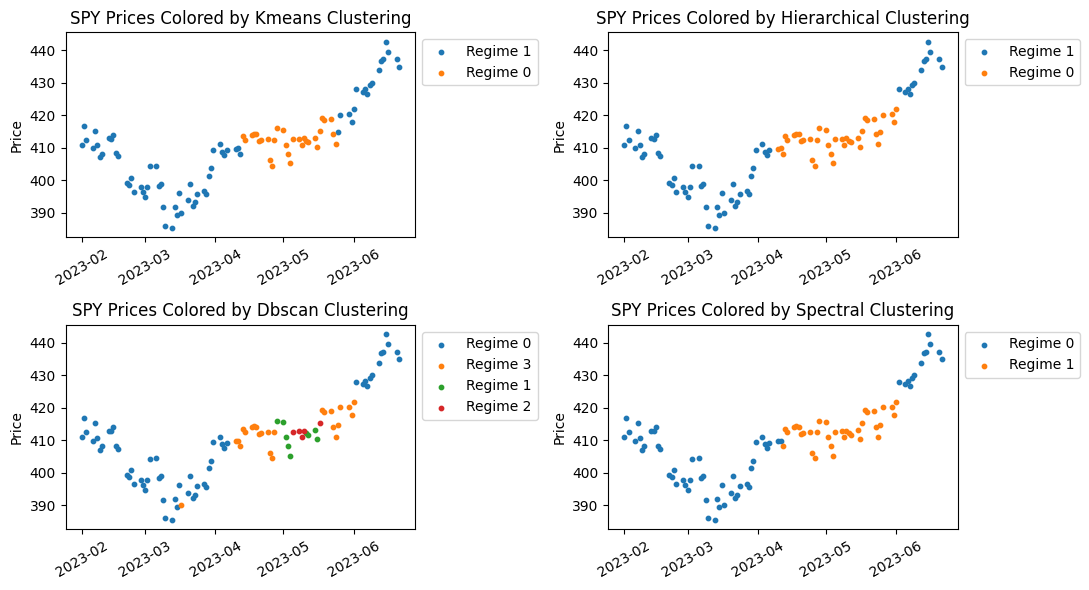

In [19]:
# REPLICATE PRICE SERIES WITH EACH CLUSTERING METHOD, COLORED BY REGIMES.
# ==============================================================================================================

def plot_regime(prices, data, s=2):
    _, axes = plt.subplots(2, 2, figsize=(11, 6))
    regimes = ['kmeans_regime', 'hierarchical_regime', 'dbscan_regime', 'spectral_regime']
    for i, ax in enumerate(axes.flatten()):
        for regime in data[regimes[i]].unique():
            subset = data[data[regimes[i]] == regime]
            ax.scatter(x=subset.index, y=prices[subset.index], label=f'Regime {regime}', s=s)
        ax.set_title(f"{ticker} Prices Colored by {regimes[i].title().replace('_', ' Clustering').replace('Regime', '')}")
        ax.set_ylabel('Price')
        ax.tick_params(axis='x', rotation=30)
        ax.legend(bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()
# --------------------------------------------------------------------------------------------------------------

plot_regime(prices, data, s=10)

In [18]:
# EXTRACT REGIME DATES.
# ==============================================================================================================

def string(date):
    return date.strftime('%Y-%m-%d')

def extract_regime_dates(data):
    regimes = ['kmeans_regime', 'hierarchical_regime', 'dbscan_regime', 'spectral_regime']
    regime_dict = {}
    for regime in regimes:
        regime_data = data[regime]
        regime_periods = []
        current_regime = regime_data[0]
        start_date = data.index[0]
        for i in range(1, len(regime_data)):
            if regime_data[i] != current_regime:
                end_date = data.index[i-1]
                regime_periods.append((f'{current_regime}', string(start_date), string(end_date)))
                start_date = data.index[i]
                current_regime = regime_data[i]
        end_date = data.index[-1]
        regime_periods.append((f'{current_regime}', string(start_date), string(end_date)))
        df = pd.DataFrame(regime_periods, columns=['Regime', 'Start Date', 'End Date'])
        regime_dict[regime] = df.set_index('Regime')
    regime_dict = {key.replace('_regime', ''): value for key, value in regime_dict.items()}
    return regime_dict
# --------------------------------------------------------------------------------------------------------------

regimes = extract_regime_dates(data)
regimes['kmeans']

,Start Date,End Date
Regime,,
1,2023-02-01,2023-04-12
0,2023-04-13,2023-05-24
1,2023-05-25,2023-06-21


#### 2023: Bearing the Burden of Bank Busts

The turbulent first half of 2023 may very well be a consequence of the destabilizing effects of the aggressive interest rate hikes in late 2022 ([the talks of which are still ongoing](https://www.cnbc.com/2023/06/21/powell-expects-more-fed-rate-hikes-ahead-as-inflation-fight-has-a-long-way-to-go.html)), coupled with [the crash of the FTX cryptocurrency exchange in November-December](https://www.investopedia.com/what-went-wrong-with-ftx-6828447). This year was also characterized series of unprecedented events unfolded that shook the financial landscape—among these was the failure of [Silicon Valley Bank (SVB) on March 10, which was swiftly followed by the downfall of Silvergate Bank and Signature Bank](https://www.theverge.com/23638474/svb-collapse-silvergate-silicon-valley-bank-tech-crypto) (more collapses followed suit). This cascade of bank failures profoundly impacted the market, and the effects manifested themselves in distinct market regimes.

<u>From February to mid-April 2023, the market was in Regime 1</u>. Intriguingly, this period encompassed the SVB's failure, an event that undeniably amplified market volatility. However, Regime 1 is characterized by relative stability punctuated by periods of mild turbulence. This could be seen as the market's temporary resilience amidst the unfolding chaos, a kind of lagged response to the initial shock of SVB's collapse.

But as the shockwaves from the successive bank failures fully permeated the market, a shift occurred: <u>by mid-April, the market transitioned into Regime 0</u>, indicative of heightened instability and unpredictability. Persisting until late May, this regime likely reflects the ripple effects of the bank failures, delayed responses, and a broader reevaluation of market risks and stability.

Interestingly, by the end of May, the market seemed to gravitate back towards stability, returning to Regime 1. This shift suggests a degree of market recovery or adaptation, albeit with residual turbulence. The persistence of this regime until the third week of June indicates a gradual calming from the previous heightened volatility. However, the return to Regime 1 doesn't necessarily indicate a full market recovery. It may simply mark a return to a state of relative stability, peppered with intermittent turbulence—an echo of the market's attempts to navigate and adjust to these seismic events.

These observations provide a compelling narrative of the market's behavior during this tumultuous period, mirroring the unfolding crisis and its aftermath. The market's responses, though slightly lagged, align reasonably with my initial assumptions. 

That said, I recognize the potential risk of fitting a narrative onto this complex scenario. This is particularly true given that the features I selected, which, though diverse, are not comprehensively representative of the market (the same goes for the usage of SPY as a proxy to the entirety of the market)—the nuanced reality may not entirely conform to the outlined story and may indeed be characterized by more idiosyncratic and/or granular behavior absent in our clusters. Despite the data lending reasonable support to this account, it's important to exercise caution in attributing causality or drawing definitive conclusions in the absence of optimal granularity in analysis.

### 8. Scoring the Clusters

We use two metrics to evaluate each clustering algorithm's performance - the **Silhouette score** and the **Calinsiki-Harabasz score**. Both can be computed using the `silhouette_score` and `calinski_harabasz_score` functions from `sklearn.metrics`.

#### Silhouette Score

The silhouette score evaluates the quality of a clustering solution. It's a measure of how similar an instance is to its own cluster compared to other clusters.

- <u>A negative silhouette score</u> suggests that the sample is, on average, closer to members of another cluster than to members of its own cluster. This indicates that the clustering solution has not accurately grouped similar instances, and the instance is likely in the wrong cluster.

- <u>A silhouette score close to zero</u> indicates that the sample is on or very close to the decision boundary between two neighboring clusters. The instance could almost be in one cluster or another.

- <u>A positive silhouette score close to +1</u> means that the sample is well inside its own cluster and far from other clusters. It's likely that the clustering solution has accurately captured the structure of the data in this case.

#### Calinski-Harabasz Score

The Calinski-Harabasz score, also known as the Variance Ratio Criterion, is a measure of the total within-cluster variance compared with the total between-cluster variance. 
The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster. The Calinski-Harabasz score is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

- <u>A low Calinski-Harabasz score</u> suggests that the clustering solution is suboptimal, with clusters not well-separated or densely packed. This could indicate a high within-cluster variance and a low between-cluster variance. The instances might be placed in the wrong clusters, similar to a negative silhouette score.

- <u>A Calinski-Harabasz score that's close to the average value</u> suggests that the instances are neither particularly well-separated nor densely packed. This could reflect a clustering solution where the instances could almost be in one cluster or another, akin to a silhouette score close to zero.

- <u>A high Calinski-Harabasz score</u> suggests that the clusters are dense and well separated, indicating a low within-cluster variance and a high between-cluster variance. The clustering solution has likely captured the structure of the data well in this case, similar to a positive silhouette score close to +1.

Here's a [good article](https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c) on the Silhouette score and the Calinski-Harabasz score.

In [13]:
# IMPORT SILHOUETTE SCORE AND CALINSKI-HARABASZ SCORE FUNCTIONS.
# ==============================================================================================================

from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [14]:
# SCORE CLUSTERS WITH SILHOUETTE SCORE AND CALINSIKI-HARABASZ SCORE.
# ==============================================================================================================

def score_clusters(data):
    cluster_labels = [column for column in data.columns if "regime" in column]
    scores = []
    for label in cluster_labels:
        cluster_data = data[data[label] != -1]  # Exclude noise points if any (specifically for DBSCAN).
        labels = cluster_data[label]
        X = cluster_data.drop(cluster_labels, axis=1)
        silhouette = silhouette_score(X, labels)
        calinski_harabasz = calinski_harabasz_score(X, labels)
        scores.append([
            label.title().replace('_', '').replace('Regime', ''),
            fmt(silhouette, 'dcm'),
            fmt(calinski_harabasz, 'dcm')
        ])

    header = ["Method", "Silhouette Score", "Calinski-Harabasz Score"]
    df = pd.DataFrame(scores, columns=header)
    return df.set_index('Method').sort_values(ascending=False, by='Silhouette Score')
# --------------------------------------------------------------------------------------------------------------

scores = score_clusters(data)
scores

,Silhouette Score,Calinski-Harabasz Score
Method,,
Kmeans,0.56,158.47
Spectral,0.52,133.53
Hierarchical,0.50,127.21
Dbscan,0.40,71.88


Among the four clustering methods used, KMeans achieved the highest Silhouette Score (0.56) and the highest Calinski Harabasz Score (155.98), indicating that it formed distinct and well-separated clusters. Hierarchical clustering showed decent performance with a Silhouette Score of 0.50 and a Calinski Harabasz Score of 124.83. Spectral clustering performed well with a Silhouette Score of 0.52 and a Calinski Harabasz Score of 132.93, particularly suitable for non-convex clusters. DBSCAN had the lowest scores, with a Silhouette Score of 0.40 and a Calinski Harabasz Score of 70.76, though it can identify noise points and clusters of various shapes. Overall, KMeans demonstrated the best clustering performance based on these metrics, followed by Spectral clustering, Hierarchical clustering, and DBSCAN.

---

## Conclusion
In this paper, I've attempted to use clustering techniques to reveal distinct regimes of the stock market in 2023, using SPY as a proxy. The four clustering methods used were K-Means, Hierarchical, DBSCAN, and Spectral clustering, and seven features were selected to encapsulate different aspects of market behavior, including returns, moving standard deviation of returns, moving average return, moving skewness of returns, moving kurtosis of returns, moving autocorrelation of returns, and jumps.

All four methods revealed similar market regimes. The analysis identified a relative stability period (Regime 1) interrupted by periods of heightened market unpredictability and volatility (Regime 0). The regimes derived aligned with significant events of 2023, such as the collapse of Silicon Valley Bank and the downfall of Silvergate Bank and Signature Bank, providing a broad overview of the market behavior during this turbulent period.

It's worth noting, however, that while clustering methods can help uncover patterns in the market and segment it into distinct regimes, they do not provide insight into the causes or implications of these regimes. Therefore, it's crucial to complement clustering with additional tools and analyses to derive meaningful interpretations and predictions. The selected features, while capturing some key aspects of market behavior, did not account for factors such as macroeconomic indicators, industry-specific information, or market sentiment that could significantly impact regime shifts. Future work could include integrating these factors into the feature set for a more comprehensive representation of market dynamics.

Despite these limitations, the current analysis illustrates the utility of clustering methods in unveiling distinct market regimes, providing an overview of market behavior during specific periods. This can assist investors in adjusting their strategies and managing their portfolios in response to changing market conditions.

Ultimately, the challenge lies not only in correctly identifying the regimes but also understanding their implications and how to navigate them effectively. This is where the combination of quantitative tools like clustering and qualitative analysis comes in, bringing together data-driven insights and nuanced interpretation of market dynamics. As the market continues to evolve, so too must our techniques and approaches to understand it, making the exploration of advanced machine learning and data science techniques in finance a continually exciting endeavor.

---

## Appendix

In this section I outline the mathematical basis behind the tools and metrics used in this paper.

### <u>Clustering</u>

#### K-Means Clustering
K-means is a centroid-based clustering algorithm. The aim of the algorithm is to partition the dataset into k clusters, each represented by the mean of the samples in the cluster (hence the name, "k-means").

The mathematical objective of K-Means clustering is to minimize the within-cluster sum of squares (WCSS), defined as:

$$\quad$$
$$\text{WCSS} = \sum_{i=1}^k \sum_{x\in{C_{i}}}\text{ }||x - \mu{_i}||^2$$
$$\quad$$
 
where $C_i$ is the $i^{th}$ cluster, $x$ is a sample in the $i^{th}$ cluster, $\mu_i$ is the centroid of the $i^{th}$ cluster, and $||x - \mu_i||^2$ is the squared Euclidean distance from a sample to its cluster's centroid.

#### Hierarchical Clustering
Hierarchical clustering is an agglomerative clustering technique that builds a hierarchy of clusters by merging or splitting existing groups. The algorithm starts with each sample as a cluster, then merges the closest pair of clusters, and continues until only one cluster (or k clusters) remain. In practice, we usually do not let the algorithm continue until there's only one cluster left. We choose an appropriate stopping point that determines the number of clusters. This could be a specific number of clusters we want (k), or based on a certain distance or similarity threshold at which we stop merging clusters. The stopping point is chosen based on the specific needs of the analysis or other statistical criteria.

There are several linkage methods, such as single linkage, complete linkage, and average linkage. `scikit-learn`'s `AgglomerativeClustering` sets its linkage parameter at initialization to `'ward'`, which minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and, in this sense, is similar to the k-means objective function but tackled with an agglomerative hierarchical approach. The formula for the Ward's method can be written as follows:

$$\quad$$
$$ d(A, B) = \sqrt{\frac{|A||B|}{|A| + |B|}\cdot{||\mu_A - \mu_B||^2}} $$
$$\quad$$

where $|A|$ and $|B|$ are the sizes of clusters $A$ and $B$, respectively, and $\mu_A$ and $\mu_B$ are the centroids (mean vectors) of clusters $A$ and $B$, respectively.

#### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
DBSCAN is a density-based clustering algorithm. The main idea is to continue growing a cluster as long as the density (number of neighboring points) exceeds a certain threshold. It's particularly well suited to tasks where you need to separate high-density clusters from low-density regions.

The algorithm works by defining a neighborhood around each data point. If there are at least a minimum number of points (MinPts) within a certain range, a new cluster is created. This process can be mathematically defined by two parameters: Eps (the maximum distance between two samples to be considered in the same neighborhood) and MinPts.

#### Spectral Clustering
Spectral clustering techniques make use of the spectrum (eigenvalues) of the similarity matrix of the data to perform dimensionality reduction before clustering in fewer dimensions. The similarity matrix is provided as input and consists of measures of the similarity of each pair of points in the dataset.

In practice, Spectral Clustering solves a normalized graph cut problem: partitioning the graph (samples are graph vertices and similarities are edge weights) into disjoint subgraphs (clusters), minimizing the sum of edge weights between different subgraphs, and maximizing the sum of edge weights within each subgraph.

The steps of spectral clustering often involve constructing a similarity graph, choosing a graph Laplacian matrix, computing the first $k$ eigenvectors of the Laplacian matrix, mapping the data into a lower-dimensional space using these eigenvectors, and finally, applying another clustering method (like K-means) in this reduced space.

### <u>The Silhouette Score and the Calinski-Harabasz Scores</u>

The silhouette score for each sample is calculated as follows:

$$s_{s} = \frac{(b - a)}{\text{max}(a,b)}$$

where $a$ is the mean distance between a sample and all other points in the same class, $b$ is the mean distance between a sample and all other points in the next nearest cluster. The silhouette score ranges between -1 and 1. A high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

The Calinski-Harabasz score is calculated as follows:

$$s_{c} = \frac{B(n-k)}{W(k-1)}$$

where $B$ is the between group dispersion matrix, which measures how much the clusters differ from each other, $W$ is the within-cluster dispersion matrix, which measures how spread out the points within each cluster are, $n$ is the total number of samples, $k$ is the number of clusters.